# CONTINUAL LEARNING using Gated Linear Networks

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')
#%cd drive/MyDrive/'Colab Notebooks'
#%cd meta-learning-course-notebooks/1_MAML/
#!ls

In [ ]:
#!pip install import_ipynb --quiet

In [ ]:
#!pip install learn2learn --quiet

In [1]:
import import_ipynb
import utils
import models
utils.hide_toggle('Imports 1')

importing Jupyter notebook from utils.ipynb
importing Jupyter notebook from models.ipynb


In [2]:
from IPython import display
import torch
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
from l2lutils import KShotLoader
from IPython import display
utils.hide_toggle('Imports 2')

importing Jupyter notebook from l2lutils.ipynb


# Data Generation and Loading

In [3]:
#Generate data - euclidean
meta_train_ds, meta_test_ds, full_loader = utils.euclideanDataset(n_samples=20000,n_features=20,n_classes=10,batch_size=32)

In [ ]:
# Define an MLP network. Note that input dimension has to be data dimension. For classification
# final dimension has to be number of classes; for regression one.
#torch.manual_seed(10)
net = models.MLP(dims=[20,32,32,10])

In [ ]:
# Train the network; note that network is trained in place so repeated calls further train it.
net,losses,accs=models.Train(net,full_loader,lr=1e-2,epochs=10,verbose=True)

In [ ]:
#Training accuracy.
models.accuracy(net,meta_train_ds.samples,meta_train_ds.labels,verbose=True)

In [ ]:
# Test accuracy.
models.accuracy(net,meta_test_ds.samples,meta_test_ds.labels)

# Meta-Learning: Tasks

Generate a k-shot n-way loader using the meta-training dataset

In [ ]:
meta_train_kloader=KShotLoader(meta_train_ds,shots=5,ways=5)

Sample a task - each task has a k-shot n-way training set and a similar test set

In [ ]:
d_train,d_test=meta_train_kloader.get_task()

Let's try directly learning using the task training set albeit its small size: create a dataset and loader and train it with the earlier network and Train function.

In [ ]:
taskds = utils.MyDS(d_train[0],d_train[1])

In [ ]:
d_train_loader = torch.utils.data.DataLoader(dataset=taskds,batch_size=1,shuffle=True)

In [ ]:
net,loss=models.Train(net,d_train_loader,lr=1e-1,epochs=10,verbose=False)

How does it do on the test set of the sampled task?

In [ ]:
models.accuracy(net,d_test[0],d_test[1])

# Gated Linear Networks

In [8]:
from pygln import GLN

## GLN Interface

### Constructor

```python
GLN(backend: str,
    layer_sizes: Sequence[int],
    input_size: int,
    context_map_size: int = 4,
    num_classes: int = 2,
    base_predictor: Optional[Callable] = None,
    learning_rate: float = 1e-4,
    pred_clipping: float = 1e-3,
    weight_clipping: float = 5.0,
    bias: bool = True,
    context_bias: bool = True)
```

Gated Linear Network constructor.

**Args:**

- **backend** (*"jax", "numpy", "pytorch", "tf"*): Which backend implementation to use.
- **layer\_sizes** (*list[int >= 1]*): List of layer output sizes.
- **input\_size** (*int >= 1*): Input vector size.
- **num\_classes** (*int >= 2*): For values >2, turns GLN into a multi-class classifier by
    internally creating a one-vs-all binary GLN classifier per class and return the argmax as
    output.
- **context\_map\_size** (*int >= 1*): Context dimension, i.e. number of context halfspaces.
- **bias** (*bool*): Whether to add a bias prediction in each layer.
- **context\_bias** (*bool*): Whether to use a random non-zero bias for context halfspace gating.
- **base\_predictor** (*np.array[N] -> np.array[M]*): If given, maps the N-dim input vector to a
    corresponding M-dim vector of base predictions (could be a constant prior), instead of
    simply using the clipped input vector itself.
- **learning\_rate** (*float > 0.0*): Update learning rate.
- **pred\_clipping** (*0.0 < float < 0.5*): Clip predictions into [p, 1 - p] at each layer.
- **weight\_clipping** (*float > 0.0*): Clip weights into [-w, w] after each update.

---

### Predict

```python
GLN.predict(input: np.ndarray,
            target: np.ndarray = None,
            return_probs: bool = False) -> np.ndarray
```

Predict the class for the given inputs, and optionally update the weights.

> **PyTorch** implementation takes `torch.Tensor`s (on the same device as the model) as parameters.

**Args:**

- **input** (*np.array[B, N]*): Batch of B N-dim float input vectors.
- **target** (*np.array[B]*): Optional batch of B bool/int target class labels which, if given,
    triggers an online update if given.
- **return\_probs** (*bool*): Whether to return the classification probability (for each
    one-vs-all classifier if num_classes given) instead of the class.

**Returns:**

- Predicted class per input instance, or classification probabilities if return_probs set.

---

Sampling a training task: Note that each of d_train and d_test is a tuple comprising of a training set, and labels.

In [ ]:
meta_train_kloader=KShotLoader(meta_train_ds,shots=100,ways=2)

In [ ]:
meta_test_kloader=KShotLoader(meta_test_ds,shots=100,ways=2)

In [ ]:
d_train,d_test=meta_train_kloader.get_task()
rp = torch.randperm(d_train[1].shape[0])
d_train0=d_train[0][rp]
d_train1=d_train[1][rp]

In [ ]:
f=(lambda x: (x - x.min(axis=1, keepdims=True)[0]) /(x.max(axis=1, keepdims=True)[0] - x.min(axis=1, keepdims=True)[0])+0.01)

In [ ]:
f=(lambda x: x/2*x)

In [ ]:
gln = GLN(backend='pytorch', layer_sizes=[4, 4, 1], input_size=20,base_predictor=f)
lossfn = torch.nn.NLLLoss()

In [ ]:
for i in range(100):
    preds = gln.predict(d_train0[i:i+50],d_train1[i:i+50],return_probs=True)
    #print(preds)
    #print(d_train[1][i:1+10].unsqueeze(0))
    pt = torch.tensor(preds).unsqueeze(-1)
    ph = torch.cat((torch.log(1-pt),torch.log(pt)),dim=1)
    loss = lossfn(ph,d_train1[i:i+50])
    #print(ph[0:10])
    #print(d_train1[i:i+10])
    print(loss)
    display.clear_output(wait=True)

In [ ]:
d_train,d_test=meta_test_kloader.get_task()

In [ ]:
preds = gln.predict(d_train[0],d_train[1],return_probs=True)
pt = torch.tensor(preds).unsqueeze(-1)
ph = torch.cat((pt,1-pt),dim=1)
lossfn(ph,d_train[1])
d_train[1]

In [ ]:
t = d_train[0][0].unsqueeze(0)
#(t.max(axis=1, keepdims=False) - t.min(axis=1, keepdims=False))
#torch.min(t,axis=1,keepdims=False)[0]
f(t)

# Putting it all together: 
# Continually Training a Gated Linear Network
Now let's put all of the above in a loop - continually training a Gated Linear Network:

In [9]:
class TaskStore():
    def __init__(self):
        self.XL = []
        self.yL = []
        self.i = 0
        self.n = 0
    def save_task(self,X,y):
        self.XL += [X]
        self.yL += [y]
        self.n += 1
    def get_task(self):
        if self.i < self.n:
            X = self.XL[self.i]
            y = self.yL[self.i]
            self.i += 1
            return X,y,False
        else:
            return self.XL[0],self.yL[0],True
    def reset(self):
        self.i = 0
        self.n = 0
    def load(self,loader,n_tasks=5):
        for t in range(n_tasks):
            d_train,d_test=loader.get_task()
            rp = torch.randperm(d_train[1].shape[0])
            d_train0=d_train[0][rp]
            d_train1=d_train[1][rp]
            rp1 = torch.randperm(d_test[1].shape[0])
            d_test0=d_test[0][rp1]
            d_test1=d_test[1][rp1]
            X = torch.cat((d_train0,d_test0),axis=0)
            y = torch.cat((d_train1,d_test1),axis=0)
            self.save_task(X,y)

In [10]:
f = (lambda x: (x - x.min(axis=1, keepdims=True)[0]) / (x.max(axis=1, keepdims=True)[0] - x.min(axis=1, keepdims=True)[0])
    )

In [11]:
def gln_acc(Net,X_test,y_test,verbose=False):
    m = X_test.shape[0]
    preds = Net.predict(X_test,return_probs=True)
    pt = torch.tensor(preds).unsqueeze(-1)
    ph = torch.cat((torch.log(1-pt),torch.log(pt)),dim=1)
    _,predicted = torch.max(ph,axis=1)
    correct = (predicted == y_test).float().sum().item()
    accuracy = correct/m
    if verbose: print(accuracy)
    return accuracy

In [12]:
import learn2learn as l2l
import numpy as np
import torch.optim as optim
shots,ways = 200,2
n_features = 20
net = GLN(learning_rate=1e-2,backend='pytorch', layer_sizes=[16, 32, 8, 1], 
          input_size=20,base_predictor=f,context_map_size=8)

In [13]:
#Meta-testing task loader for later.
meta_test_kloader=KShotLoader(meta_test_ds,shots=shots,ways=ways)
meta_train_kloader=KShotLoader(meta_train_ds,shots=shots,ways=ways,num_tasks=1000)

In [14]:
trainStore = TaskStore()
testStore = TaskStore()

In [15]:
trainStore.load(meta_train_kloader,n_tasks=25)
testStore.load(meta_test_kloader,n_tasks=25)

In [16]:
def runGLN(net,task_store,learn=True,task_count=5,batch_size=32,epochs=1,frac=1.0):
    lossfn = torch.nn.NLLLoss()
    bs = batch_size
    lossL=[]
    accs_trainL=[]
    accs_testL=[]
    accsL=[]
    n_batch = 0
    start = shots
    for task in range(task_count):
        task_loss = 0.0
        # load task and train/predict on it
        X,y,_ = task_store.get_task()
        i = 0
        n = int(X.shape[0]/2)
        n_train = int(n/frac)
        for e in range(epochs):
            while (i<n_train-bs):
                if learn==True: preds = net.predict(X[i:i+bs],y[i:i+bs],return_probs=True)
                else: preds = net.predict(X[i:i+bs],return_probs=True)
                pt = torch.tensor(preds).unsqueeze(-1)
                ph = torch.cat((torch.log(1-pt),torch.log(pt)),dim=1)
                loss = lossfn(ph,y[i:i+bs])
                lossL+=[loss]
                n_batch+=1
                i+=bs
        # Training accuracy
        acc_train = gln_acc(net,X[0:n],y[0:n])
        # Test accuracy
        acc_test = gln_acc(net,X[n:2*n],y[n:2*n])
        acc = (acc_train+acc_test)/2
        accsL += [acc]
        accs_trainL += [acc_train]
        accs_testL += [acc_test]
        print("Task:",task,sum(lossL)/n_batch,acc_train,acc_test)
    return lossL,accsL,accs_trainL,accs_testL

    

In [17]:
trainStore.i=0
testStore.i=0

In [18]:
lossL1,accsA1,accsTr1,accsTe1=runGLN(net,trainStore,epochs=1,task_count=25)
#gln_acc(net,X,y)

Task: 0 tensor(0.4707) 0.995 0.96
Task: 1 tensor(0.3424) 1.0 0.985
Task: 2 tensor(0.2639) 1.0 0.985
Task: 3 tensor(0.3385) 0.99 0.9325
Task: 4 tensor(0.3432) 0.9925 0.97
Task: 5 tensor(0.4724) 0.9825 0.8725
Task: 6 tensor(0.4799) 0.995 0.9575
Task: 7 tensor(0.4885) 0.995 0.955
Task: 8 tensor(0.4569) 0.99 0.9825
Task: 9 tensor(0.4487) 0.99 0.9475
Task: 10 tensor(0.4432) 0.9775 0.885
Task: 11 tensor(0.4134) 0.995 0.9925
Task: 12 tensor(0.4263) 0.995 0.945
Task: 13 tensor(0.4466) 0.9575 0.875
Task: 14 tensor(0.4500) 0.9875 0.93
Task: 15 tensor(0.4383) 1.0 0.9675
Task: 16 tensor(0.4391) 0.975 0.91
Task: 17 tensor(0.4611) 0.8925 0.8525
Task: 18 tensor(0.4574) 0.995 0.965
Task: 19 tensor(0.4722) 0.9775 0.94
Task: 20 tensor(0.4698) 0.9925 0.9425
Task: 21 tensor(0.4892) 0.9275 0.8025
Task: 22 tensor(0.4818) 0.9875 0.955
Task: 23 tensor(0.4943) 0.985 0.9175
Task: 24 tensor(0.4998) 0.9625 0.92


In [19]:
trainStore.i=0
lossL2,accsA2,accsTr2,accsTe2=runGLN(net,trainStore,learn=False,epochs=1,task_count=25)

Task: 0 tensor(0.5946) 0.6575 0.6475
Task: 1 tensor(0.5563) 0.7525 0.7375
Task: 2 tensor(0.5788) 0.6325 0.6325
Task: 3 tensor(0.6682) 0.5 0.4925
Task: 4 tensor(0.5842) 0.93 0.9325
Task: 5 tensor(0.6376) 0.36 0.23
Task: 6 tensor(0.7322) 0.355 0.34
Task: 7 tensor(0.7577) 0.445 0.43
Task: 8 tensor(0.8078) 0.43 0.4075
Task: 9 tensor(0.8244) 0.475 0.42
Task: 10 tensor(0.8424) 0.49 0.4725
Task: 11 tensor(0.9129) 0.08 0.0525
Task: 12 tensor(0.9034) 0.565 0.5625
Task: 13 tensor(0.9672) 0.105 0.095
Task: 14 tensor(0.9342) 0.7725 0.7525
Task: 15 tensor(0.8986) 0.8375 0.8275
Task: 16 tensor(0.9303) 0.1525 0.1625
Task: 17 tensor(0.9096) 0.655 0.565
Task: 18 tensor(0.8851) 0.8125 0.7225
Task: 19 tensor(0.8607) 0.8525 0.735
Task: 20 tensor(0.8591) 0.53 0.5375
Task: 21 tensor(0.8546) 0.54 0.4775
Task: 22 tensor(0.8488) 0.56 0.4725
Task: 23 tensor(0.8205) 0.985 0.92
Task: 24 tensor(0.7949) 0.9625 0.92


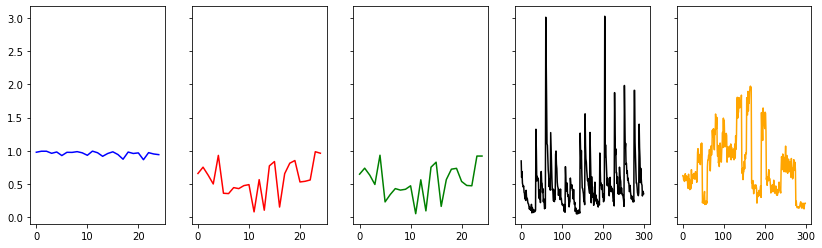

In [20]:
_,(ax1,ax2,ax3,ax4,ax5) = plt.subplots(1,5,sharey=True,figsize=(14,4))
ax1.plot(accsA1,color='blue') # - train on 25 tasks (avg acc of train and test during training)
ax2.plot(accsTr2,color='red')  # - test on data same 25 tasks
ax3.plot(accsTe2,color='green') # - test on test data of same 25 tasks
ax4.plot(lossL1,color='black') # - losses during first training
ax5.plot(lossL2,color='orange') # - losses post training on all tasks without more training 

In [21]:
print("Average accuracy while training on all tasks:",np.sum(accsTe1)/25)

Average accuracy while training on all tasks: 0.9339000000000002


In [22]:
print("Average accuracy after training on all tasks:",np.sum(accsTr2)/25)

Average accuracy after training on all tasks: 0.5775000000000001


In [ ]:
trainStore.i=0
lossL3,accsA3,accsTr3,accsTe3=runGLN(net,trainStore,epochs=1,task_count=25,frac=1,batch_size=10)

In [ ]:
_,(ax1,ax2,ax3,ax4,ax5) = plt.subplots(1,5,sharey=True,figsize=(14,4))
ax1.plot(accsA1,color='blue') # - train on 25 tasks
ax2.plot(accsA2,color='red')  # - test again on same 25 tasks
ax3.plot(accsA3,color='green') # - train again with 1/10 data 
ax4.plot(accsTr3,color='black') # - training accuracies
ax5.plot(accsTe3,color='orange') # - test accuracies

In [ ]:
trainStore.i=0
testStore.i=0
lossL4,accsA4,accsTr4,accsTe4=runGLN(net,testStore,epochs=1,task_count=25,batch_size=32)

In [ ]:
_,(ax1,ax2,ax3,ax4,ax5) = plt.subplots(1,5,sharey=True,figsize=(14,4))
ax1.plot(lossL1,color='blue') # - train on 25 tasks
ax2.plot(lossL4,color='red')  # - train on new 25 tasks
ax3.plot(accsA1,color='green') # - accuraciess on training data of first 25 tasks
ax4.plot(accsA4,color='black') # - accuracies new tasks 25 tasks
ax5.plot(accsTe4,color='orange') # - test accuracies on new 25 tasks

# HW4: 
(i) Experiment with network and context sizes (ii) Try with standard MLP of similar architecture (number of neurons) and compare forgetting and forward transfer, backward negative transfer etc.